In [1]:
import os
import csv
import time
import copy
import random
from collections import Counter, defaultdict
from heapq import nlargest

import numpy as np
import pandas as pd
from scipy import stats
import scipy.sparse.linalg as linalg
import powerlaw

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import seaborn as sns

# Network analysis
import networkx as nx
from networkx.algorithms.community import (
    greedy_modularity_communities,
    label_propagation_communities,
    modularity,
    partition_quality
)

import community as community_louvain

In [2]:
# Reproducibility
SEED = 69069


random.seed(SEED)           # For basic Python random
np.random.seed(SEED)        # For NumPy (Null models, stats)
os.environ['PYTHONHASHSEED'] = str(SEED) # For dictionary/set consistency

# Styling Settings
plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 22,
    "font.size": 24,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "axes.spines.top": False,    
    "axes.spines.right": False,  
    "pdf.fonttype": 42,      
    "ps.fonttype": 42,
})

In [3]:
# Load data (store weights but do not use them)
G_raw = nx.Graph()

data_filename = "data/ingredients_network.csv"

with open(data_filename, newline='', encoding="utf-8") as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0].startswith("#"):
            continue
        ing1, ing2, weight = row
        G_raw.add_edge(ing1, ing2, weight=int(weight))

print("Raw network:")
print("Nodes:", G_raw.number_of_nodes())
print("Edges:", G_raw.number_of_edges())

# Compute degrees
degrees_raw = np.array([deg for node, deg in G_raw.degree()])
mean_degree_raw = np.mean(degrees_raw)
std_degree_raw = np.std(degrees_raw)

print("Mean degree:", mean_degree_raw)
print("Standard deviation of degrees:", std_degree_raw)


Raw network:
Nodes: 1507
Edges: 221777
Mean degree: 294.3291307232913
Standard deviation of degrees: 285.74924709803594


In [4]:
# Largest connected component
if not nx.is_connected(G_raw):
    largest_cc = max(nx.connected_components(G_raw), key=len)
    G = G_raw.subgraph(largest_cc).copy()
else:
    G = G_raw.copy()

print("\nLargest connected component:")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())




Largest connected component:
Nodes: 1496
Edges: 221754


In [5]:
# Basic descriptors
N = G.number_of_nodes()
E = G.number_of_edges()
density = nx.density(G)

print("\nBasic descriptors:")
print(f"N = {N}")
print(f"E = {E}")
print(f"Density = {density:.6f}")
# Compute degrees
degrees = np.array([deg for node, deg in G.degree()])
mean_degree = np.mean(degrees)
std_degree = np.std(degrees)

print("Mean degree:", mean_degree)
print("Standard deviation of degrees:", std_degree)




Basic descriptors:
N = 1496
E = 221754
Density = 0.198303
Mean degree: 296.46256684491976
Standard deviation of degrees: 285.7086179557067


# Centrality measures

In [6]:
# Preparations for Katz centrality:
adj_matrix = nx.to_scipy_sparse_array(G, dtype=float)

# Calculate the largest eigenvalue
eigenvalues = linalg.eigsh(adj_matrix, k=1, which='LM', return_eigenvectors=False)
lambda_max = eigenvalues[0]

# Set alpha safely below 1/lambda_max
safe_alpha = 0.5 / lambda_max 

print(f"λ_max: {lambda_max:.4f}")
print(f"Set alpha below the Convergence Limit (1/λ_max): {1/lambda_max:.6f}")
print(f"Using alpha: {safe_alpha:.6f}")

λ_max: 11334.7789
Set alpha below the Convergence Limit (1/λ_max): 0.000088
Using alpha: 0.000044


In [7]:
centralities = {}
timings = {}

# Degree centrality
start = time.time()
centralities["degree"] = dict(G.degree())
timings["degree"] = time.time() - start

# Closeness centrality
start = time.time()
centralities["closeness"] = nx.closeness_centrality(G)
timings["closeness"] = time.time() - start

# Betweenness centrality
start = time.time()
centralities["betweenness"] = nx.betweenness_centrality(G)
timings["betweenness"] = time.time() - start

# Eigenvector centrality
start = time.time()
centralities["eigenvector"] = nx.eigenvector_centrality_numpy(G)
timings["eigenvector"] = time.time() - start

# Katz centrality
start = time.time()
centralities["katz"] = nx.katz_centrality_numpy(G, alpha=safe_alpha, beta=1.0)
timings["katz"] = time.time() - start

# PageRank
start = time.time()
centralities["pagerank"] = nx.pagerank(G)
timings["pagerank"] = time.time() - start

# Subgraph centrality
start = time.time()
centralities["subgraph"] = nx.subgraph_centrality(G)
timings["subgraph"] = time.time() - start

In [8]:
# Weighted Centrality measures
start_time = time.time()

centralities_weighted = {}

# Weighted Degree
centralities_weighted["degree"] = dict(G.degree(weight='weight'))


# Weighted Closeness where distance='weight' assumes weights are "costs" (higher = further apart)
G_inv_dist = G.copy()
for u, v, d in G_inv_dist.edges(data=True):
    d['distance'] = 1.0 / d['weight']

centralities_weighted["closeness"] = nx.closeness_centrality(G_inv_dist, distance='distance')

# Weighted Betweenness the same as closeness centrality, higher weights, less similar nodes (which is not our case)
centralities_weighted["betweenness"] = nx.betweenness_centrality(
    G_inv_dist, weight='distance'
)

# Weighted Eigenvector
centralities_weighted["eigenvector"] = nx.eigenvector_centrality_numpy(G, weight='weight')

# Weighted Katz
centralities_weighted["katz"] = nx.katz_centrality_numpy(G, weight='weight', alpha=safe_alpha, beta=1.0)

# Weighted PageRank
centralities_weighted["pagerank"] = nx.pagerank(G, weight='weight')

# Subgraph Centrality 
# Note: NetworkX's subgraph_centrality does not support weights natively.

In [9]:
# Create a dictionary to store ordered top-25 lists
top25_nodes = {}

for name, cent in centralities.items():
    # Sort and take top 25
    top25 = nlargest(25, cent.items(), key=lambda x: x[1])
    
    # Keep only node names, in order
    top25_nodes[name] = [node for node, _ in top25]

# Build ranking index (1st to 25th)
rank_index = [f"{i}." for i in range(1, 26)]

top25_df = pd.DataFrame(top25_nodes, index=rank_index)

top25_df

,degree,closeness,betweenness,eigenvector,katz,pagerank,subgraph
1.,black_tea,black_tea,black_tea,black_tea,black_tea,black_tea,black_tea
2.,green_tea,green_tea,ginger,roasted_green_tea,green_tea,roasted_green_tea,green_tea
3.,roasted_green_tea,roasted_green_tea,french_lavender,green_tea,roasted_green_tea,green_tea,roasted_green_tea
4.,bantu_beer,bantu_beer,raspberry,fermented_tea,bantu_beer,bantu_beer,fermented_tea
5.,fermented_tea,fermented_tea,israeli_orange,rooibus_tea,fermented_tea,beer,rooibus_tea
6.,beer,beer,coriander,ceylon_tea,rooibus_tea,fermented_tea,ceylon_tea
7.,rooibus_tea,rooibus_tea,orange,seychelles_tea,beer,rooibus_tea,seychelles_tea
8.,ceylon_tea,strawberry,california_orange,dried_black_tea,seychelles_tea,strawberry,dried_green_tea
9.,seychelles_tea,ceylon_tea,cinnamon,dried_green_tea,ceylon_tea,roasted_beef,dried_black_tea
10.,strawberry,seychelles_tea,vanilla,pouching_tea,strawberry,ceylon_tea,kola_tea


In [10]:
# Create a dictionary to store ordered top-25 lists
top25_nodes_weight = {}

for name, cent in centralities_weighted.items():
    # Sort and take top 25
    top25 = nlargest(25, cent.items(), key=lambda x: x[1])
    
    # Keep only node names, in order
    top25_nodes_weight[name] = [node for node, _ in top25]

# Build ranking index (1st to 25th)
rank_index = [f"{i}." for i in range(1, 26)]

top25_df_weight = pd.DataFrame(top25_nodes_weight, index=rank_index)

top25_df_weight

,degree,closeness,betweenness,eigenvector,katz,pagerank
1.,black_tea,black_tea,black_tea,black_tea,black_tea,black_tea
2.,roasted_beef,roasted_green_tea,strawberry,roasted_beef,roasted_beef,roasted_green_tea
3.,bantu_beer,green_tea,roasted_beef,fried_beef,grilled_beef,green_tea
4.,beer,rooibus_tea,ginger,grilled_beef,bantu_beer,bantu_beer
5.,grilled_beef,fermented_tea,bantu_beer,bantu_beer,fried_beef,beer
6.,roasted_green_tea,strawberry,white_wine,boiled_beef,beer,fermented_tea
7.,green_tea,ceylon_tea,coffee,beer,boiled_beef,rooibus_tea
8.,fried_beef,bantu_beer,israeli_orange,beef,beef,strawberry
9.,boiled_beef,seychelles_tea,cooked_apple,raw_beef,raw_beef,roasted_beef
10.,fermented_tea,pouching_tea,bell_pepper,parmesan_cheese,roasted_green_tea,ceylon_tea


In [11]:
# Print time taken for each centrality
print("\nTime taken per centrality (seconds):")
for name, t in timings.items():
    print(f"{name:12s}: {t:.2f}")


Time taken per centrality (seconds):
degree      : 0.00
closeness   : 132.95
betweenness : 252.83
eigenvector : 0.60
katz        : 0.65
pagerank    : 0.47
subgraph    : 1.22


In [12]:
# Compute combined centrality score based on 1/rank
centrality_scores = defaultdict(float)

for cname, cent_dict in centralities_weighted.items():
    # Sort descending by centrality value and take top 25
    top25 = sorted(cent_dict.items(), key=lambda x: x[1], reverse=True)[:25]
    
    # Assign 1/rank to each node
    for rank, (node, value) in enumerate(top25, start=1):
        centrality_scores[node] += 1.0 / rank

print("\nCombined Centrality Scores:")
for node, score in sorted(centrality_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{node:25s} {score:.4f}")


Combined Centrality Scores:
black_tea                 6.0000
roasted_beef              1.9944
roasted_green_tea         1.4201
bantu_beer                1.3583
green_tea                 1.0314
grilled_beef              0.9502
beer                      0.8706
strawberry                0.8317
fried_beef                0.7473
fermented_tea             0.6205
rooibus_tea               0.6126
boiled_beef               0.5023
ceylon_tea                0.4288
parmesan_cheese           0.3875
seychelles_tea            0.3631
raw_beef                  0.3531
pouching_tea              0.3468
kola_tea                  0.3451
beef                      0.3333
dried_black_tea           0.3143
dried_green_tea           0.2945
jasmine_tea               0.2911
white_wine                0.2669
tea                       0.2546
ginger                    0.2500
fermented_russian_black_tea 0.2457
brewed_tea                0.2322
cooked_apple              0.1528
coffee                    0.1429
israeli_oran

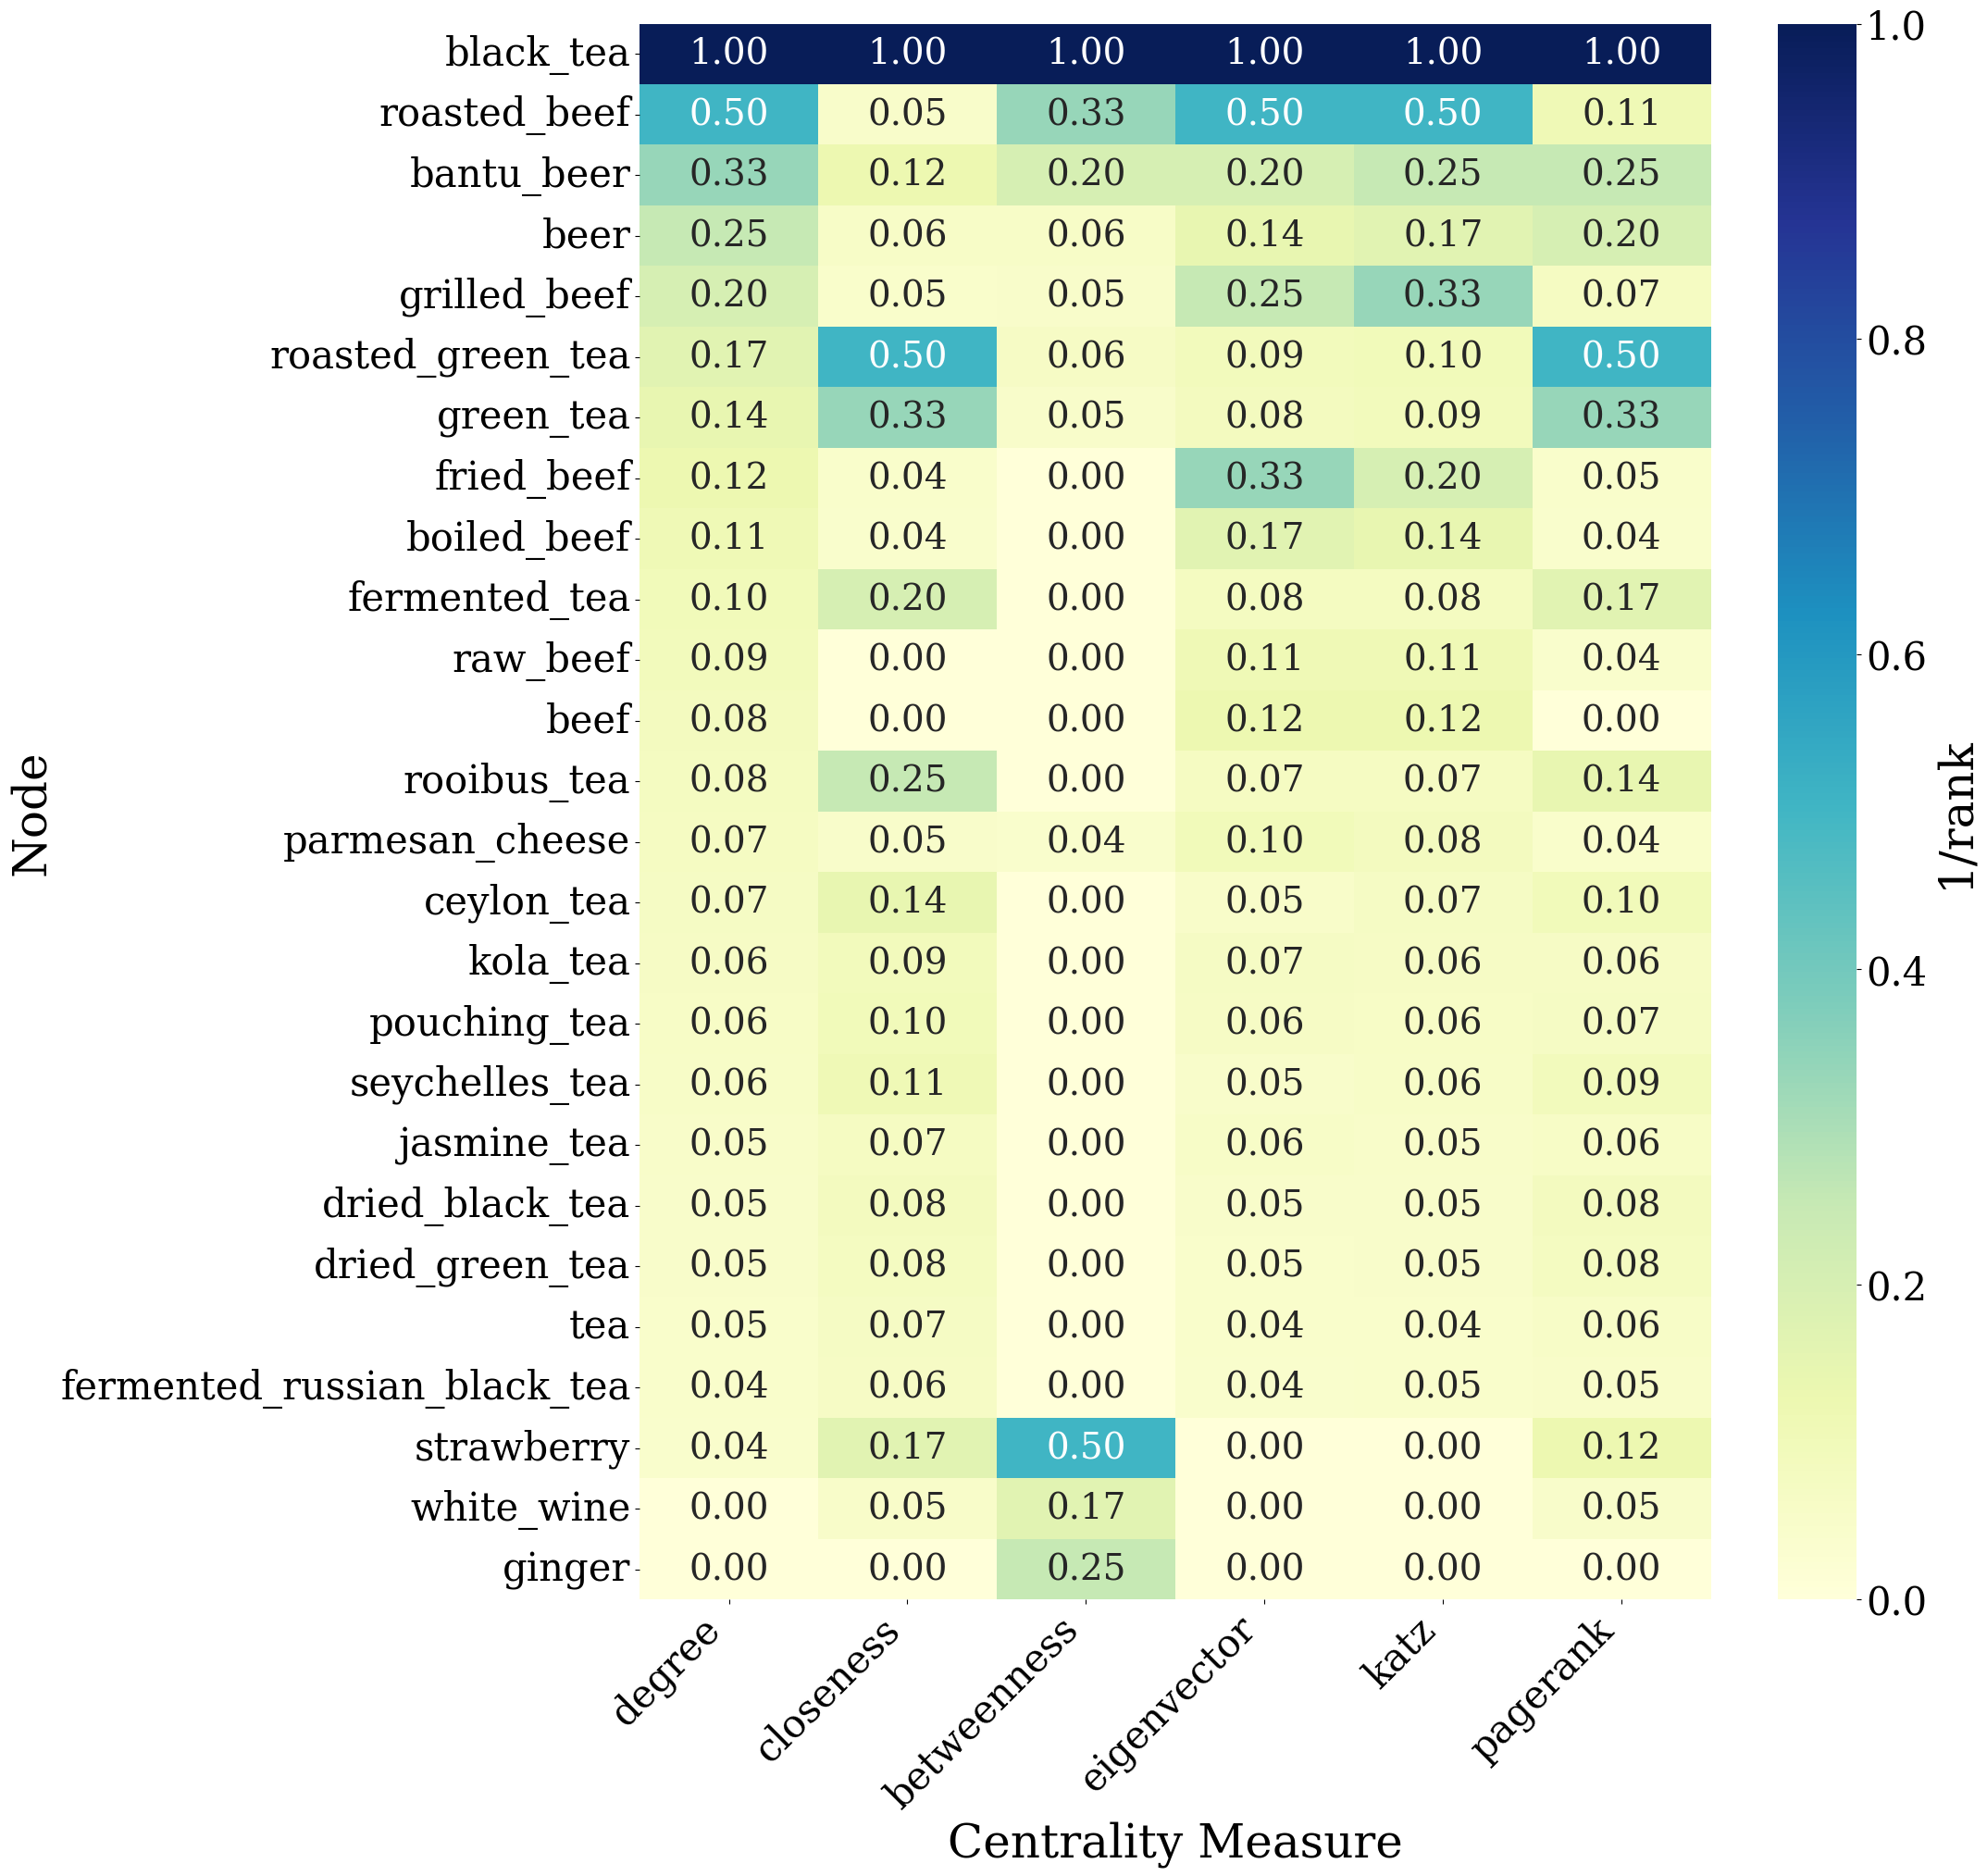

In [13]:
# Filter nodes with combined score >= 0.24
threshold = 6 / 25  # 0.24
filtered_nodes = [node for node, score in centrality_scores.items() if score >= threshold]

heatmap_data = pd.DataFrame(index=filtered_nodes, columns=centralities_weighted.keys())

for cname, cent_dict in centralities_weighted.items():
    # Top 25 nodes for this centrality
    top25 = sorted(cent_dict.items(), key=lambda x: x[1], reverse=True)[:25]
    for rank, (node, value) in enumerate(top25, start=1):
        if node in filtered_nodes:
            heatmap_data.loc[node, cname] = 1.0 / rank

# Fill missing values with 0 (nodes not in top 25 for a centrality)
heatmap_data = heatmap_data.fillna(0)

heatmap_data = heatmap_data.astype(float)

plt.figure(figsize=(22, len(filtered_nodes) * 0.8))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={'label': '1/rank'},
    annot_kws={"size": 28}
)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=30, rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=30, rotation=0)

# Make colorbar label bigger
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30) 
cbar.set_label('1/rank', fontsize=36)
# plt.title("Node Centrality Heatmap (Filtered by Combined Centrality Score >= 0.24)")
plt.xlabel("Centrality Measure", fontsize = 36)
plt.ylabel("Node", fontsize = 36)

plt.tight_layout()
plt.savefig("top_25_centrality_weighted.pdf")
plt.show()

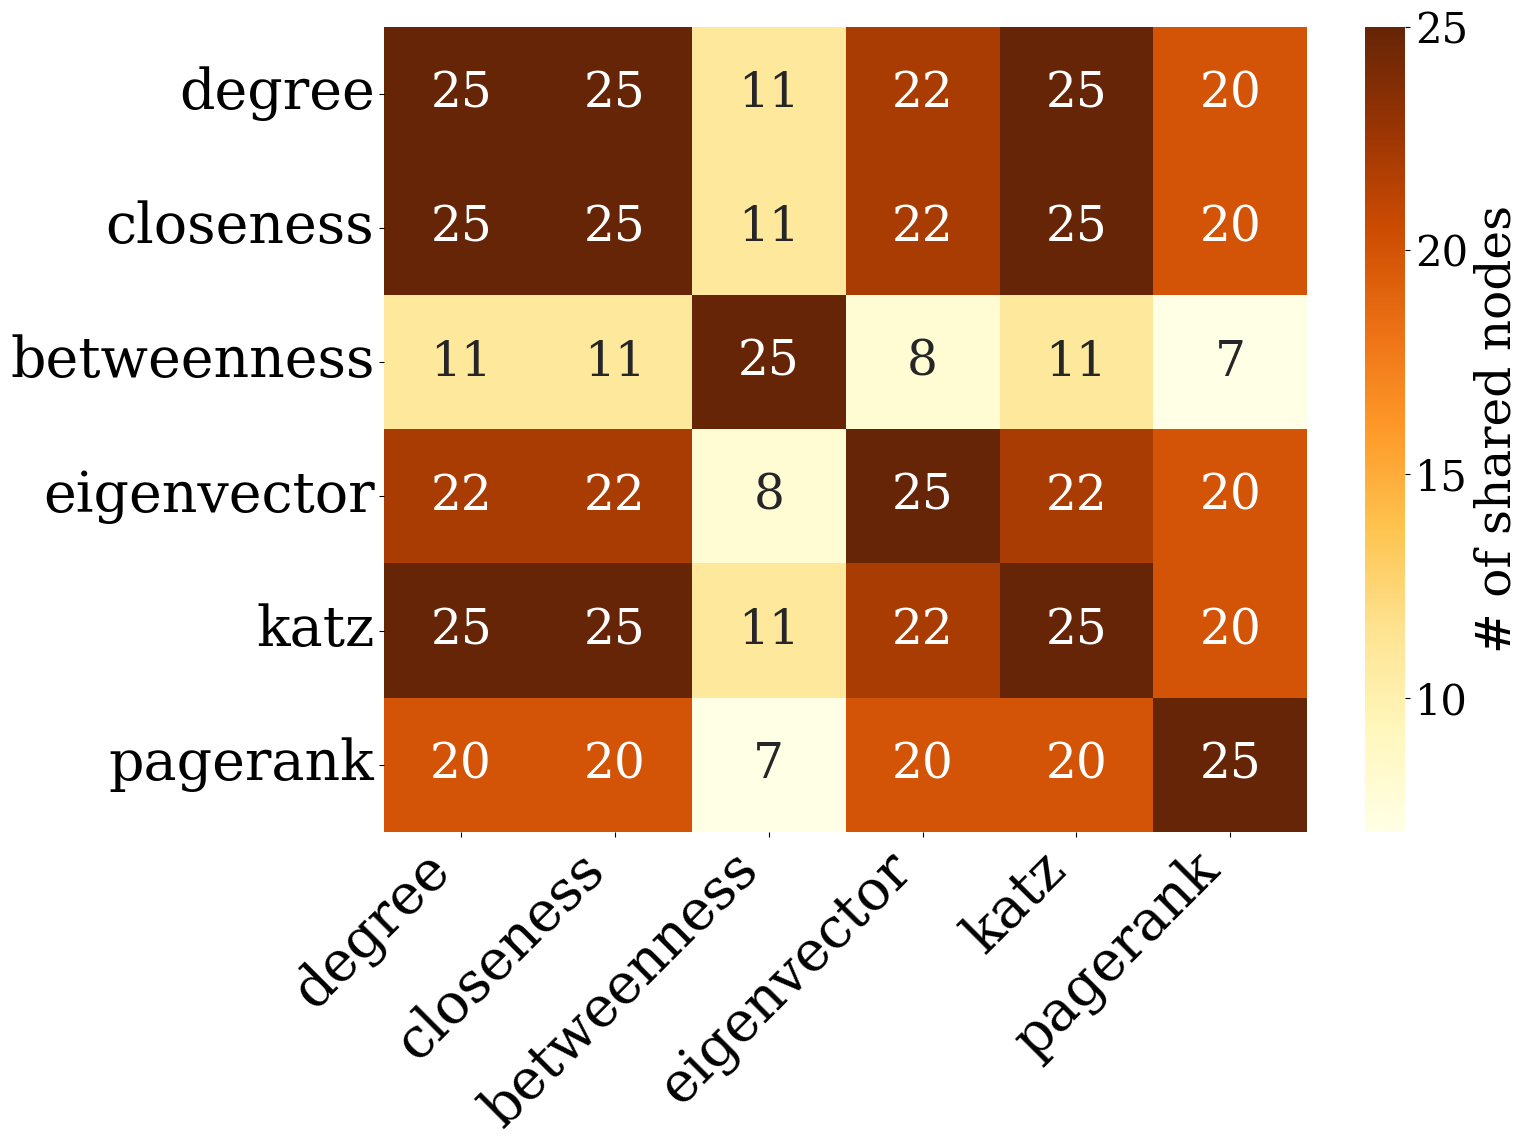

In [14]:
centrality_names = list(top25_nodes_weight.keys())
n_centralities = len(centrality_names)

co_occurrence = np.zeros((n_centralities, n_centralities), dtype=int)

for i, ci in enumerate(centrality_names):
    for j, cj in enumerate(centrality_names):
        co_occurrence[i, j] = len(
            set(top25_nodes[ci]) & set(top25_nodes[cj])
        )

co_occurrence_df = pd.DataFrame(
    co_occurrence,
    index=centrality_names,
    columns=centrality_names
)

plt.figure(figsize=(16,12))
ax = sns.heatmap(
    co_occurrence_df,
    annot=True,
    fmt="d",
    cmap="YlOrBr",
    cbar_kws={'label': '# of shared nodes'},
    annot_kws={"size": 35}
)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=40, rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=40, rotation=0)

# Make colorbar label bigger
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
cbar.ax.tick_params(labelsize=30) 
cbar.set_label('# of shared nodes', fontsize=35)  

plt.tight_layout()
plt.savefig("Pairwise_comparison_weighted.pdf")
plt.show()

In [15]:
overlap_results = []

common_centralities = set(top25_nodes.keys()) & set(top25_nodes_weight.keys())

for cname in sorted(common_centralities):
    unweighted_set = set(top25_nodes[cname])
    weighted_set   = set(top25_nodes_weight[cname])

    shared = unweighted_set & weighted_set

    overlap_results.append({
        "Centrality": cname,
        "Overlap (Top 25)": len(shared),
        "Overlap (%)": 100 * len(shared) / 25
    })

overlap_df = pd.DataFrame(overlap_results)
print(overlap_df)



    Centrality  Overlap (Top 25)  Overlap (%)
0  betweenness                17         68.0
1    closeness                20         80.0
2       degree                19         76.0
3  eigenvector                19         76.0
4         katz                19         76.0
5     pagerank                25        100.0


In [16]:
print(
    overlap_df[["Centrality", "Overlap (Top 25)", "Overlap (%)"]]
    .to_latex(index=False, float_format="%.1f")
)


\begin{tabular}{lrr}
\toprule
Centrality & Overlap (Top 25) & Overlap (%) \\
\midrule
betweenness & 17 & 68.0 \\
closeness & 20 & 80.0 \\
degree & 19 & 76.0 \\
eigenvector & 19 & 76.0 \\
katz & 19 & 76.0 \\
pagerank & 25 & 100.0 \\
\bottomrule
\end{tabular}

